In [84]:
import pandas as pd
import geopandas as gpd
import numpy as np

In [90]:
#colnames_echo=['dataid', 'long', 'lat', 'meandepth', 'shallow', 'intermediate', 'deep', 'total'] 
df_echo = pd.read_csv('leg4_echo_prepped.csv')
df_sensors = pd.read_csv('leg4_prepped.csv')

In [91]:
df_echo.dataid
# datetime type is converted as object when saved to csv, convert back to datetime after reading
df_echo.dataid = pd.to_datetime(df_echo.dataid, format='%Y-%m-%d %H:%M:%S')
df_sensors.dataid = pd.to_datetime(df_sensors.dataid, format='%Y-%m-%d %H:%M:%S')


In [92]:
# avg salinity in atlantic is 33-37 ppm, median in dataset is 35.179. Replace all values below 30 (outliers) with median
salinity_median = df_sensors['FerryBox.SBE45_Salinity'].median()
df_sensors['FerryBox.SBE45_Salinity'] = np.where(df_sensors['FerryBox.SBE45_Salinity']<=30 , salinity_median, df_sensors['FerryBox.SBE45_Salinity'])

conduc_median = df_sensors['FerryBox.SBE45_Conductivity'].median()
df_sensors['FerryBox.SBE45_Conductivity'] = np.where(df_sensors['FerryBox.SBE45_Conductivity']<=3 , conduc_median, df_sensors['FerryBox.SBE45_Conductivity'])


In [93]:
sensors_copy = pd.DataFrame.copy(df_sensors) 

sensors_copy = sensors_copy.fillna(0)
#sensors_copy.drop(sensors_copy[sensors_copy['PCO2.H2O_mmm'] == 0.00].index, inplace = True)
#ferrybox_data_c.dataid = pd.to_datetime(ferrybox_data_c.dataid, format='%Y-%m-%d %H:%M:%S')
sensors_copy

,dataid,PCO2.H2O_mmm,PCO2.CO2_umm,PCO2.atm_cond,NMEA.Humidity,NMEA.Trykk,FerryBox.SBE45_Salinity,FerryBox.SBE45_Conductivity,FerryBox.Optode_Saturation,FerryBox.C3_Turbidity,FerryBox.C3_CHLAFluorescence,FerryBox.C3_Temperature,FerryBox.C3_CDOMFluorescence
0,2022-01-05 21:53:00,1.16,423.980011,9.95,95.500000,1009.493347,35.179001,5.198,94.070000,2.090000,-0.49,14.030000,-0.04
1,2022-01-05 21:55:00,1.15,424.260010,9.95,95.985718,1009.416687,35.179001,5.198,93.099998,2.100000,-0.51,13.760000,-0.18
2,2022-01-05 21:56:00,1.15,425.109985,9.94,95.120003,1009.395996,35.179001,5.198,93.940002,2.070000,-0.51,14.310000,-0.16
3,2022-01-05 21:58:00,1.15,425.809998,9.94,96.233330,1009.341431,35.179001,5.198,93.370003,2.130000,-0.52,13.850000,-0.26
4,2022-01-05 21:59:00,1.14,426.250000,9.94,95.785713,1009.354980,35.179001,5.198,93.110001,2.150000,-0.51,13.780000,-0.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54358,2022-02-24 00:01:00,0.00,0.000000,0.00,0.000000,0.000000,35.179001,5.198,74.379997,136.979996,-0.27,43.590000,-0.14
54359,2022-02-25 09:57:00,0.00,0.000000,0.00,0.000000,0.000000,35.179001,5.198,67.050003,106.300003,-0.22,41.259998,-0.04
54360,2022-02-25 15:08:00,0.00,0.000000,0.00,0.000000,0.000000,35.179001,5.198,66.089996,179.179993,-0.31,41.200001,-0.01
54361,2022-02-27 22:06:00,0.00,0.000000,0.00,0.000000,0.000000,35.590000,5.683,95.480003,-0.380000,-0.45,27.709999,-0.20


AttributeError: 'NoneType' object has no attribute 'describe'

In [37]:
#sensors_copy = sensors_copy[sensors_copy.between(sensors_copy.quantile(.15), sensors_copy.quantile(.85))] # without outliers

AttributeError: 'DataFrame' object has no attribute 'between'

In [94]:
sensors_copy = sensors_copy.groupby(pd.Grouper(key="dataid", freq="30T")).median()

sensors_copy

,PCO2.H2O_mmm,PCO2.CO2_umm,PCO2.atm_cond,NMEA.Humidity,NMEA.Trykk,FerryBox.SBE45_Salinity,FerryBox.SBE45_Conductivity,FerryBox.Optode_Saturation,FerryBox.C3_Turbidity,FerryBox.C3_CHLAFluorescence,FerryBox.C3_Temperature,FerryBox.C3_CDOMFluorescence
dataid,,,,,,,,,,,,
2022-01-05 00:30:00,0.0,0.0,0.0,63.547144,1026.133545,35.179001,5.1980,92.405003,2.310,-0.495,12.605000,-0.190
2022-01-05 01:00:00,0.0,0.0,0.0,60.220238,1026.359985,35.179001,5.1980,92.570000,2.315,-0.490,12.840000,-0.140
2022-01-05 01:30:00,0.0,0.0,0.0,60.566666,1026.438538,35.179001,5.1980,92.550003,2.300,-0.490,12.865000,-0.160
2022-01-05 02:00:00,0.0,0.0,0.0,61.599998,1026.445496,35.179001,5.1980,92.610001,2.310,-0.490,12.860000,-0.190
2022-01-05 02:30:00,0.0,0.0,0.0,61.101189,1026.582458,35.179001,5.1980,92.660000,2.300,-0.490,13.030000,-0.170
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-28 07:30:00,0.0,0.0,0.0,77.129997,1011.298828,35.644001,5.6905,94.639999,-0.370,-0.460,27.700001,-0.135
2022-02-28 08:00:00,0.0,0.0,0.0,74.914284,1011.019165,35.597500,5.6845,94.570000,-0.380,-0.460,27.719999,-0.120
2022-02-28 08:30:00,0.0,0.0,0.0,76.198334,1010.271667,35.618500,5.6870,94.540001,-0.390,-0.460,27.709999,-0.150


In [95]:
final_df = df_echo.join(sensors_copy, on='dataid', how='inner')
final_df.dataid = pd.to_numeric(final_df.dataid)

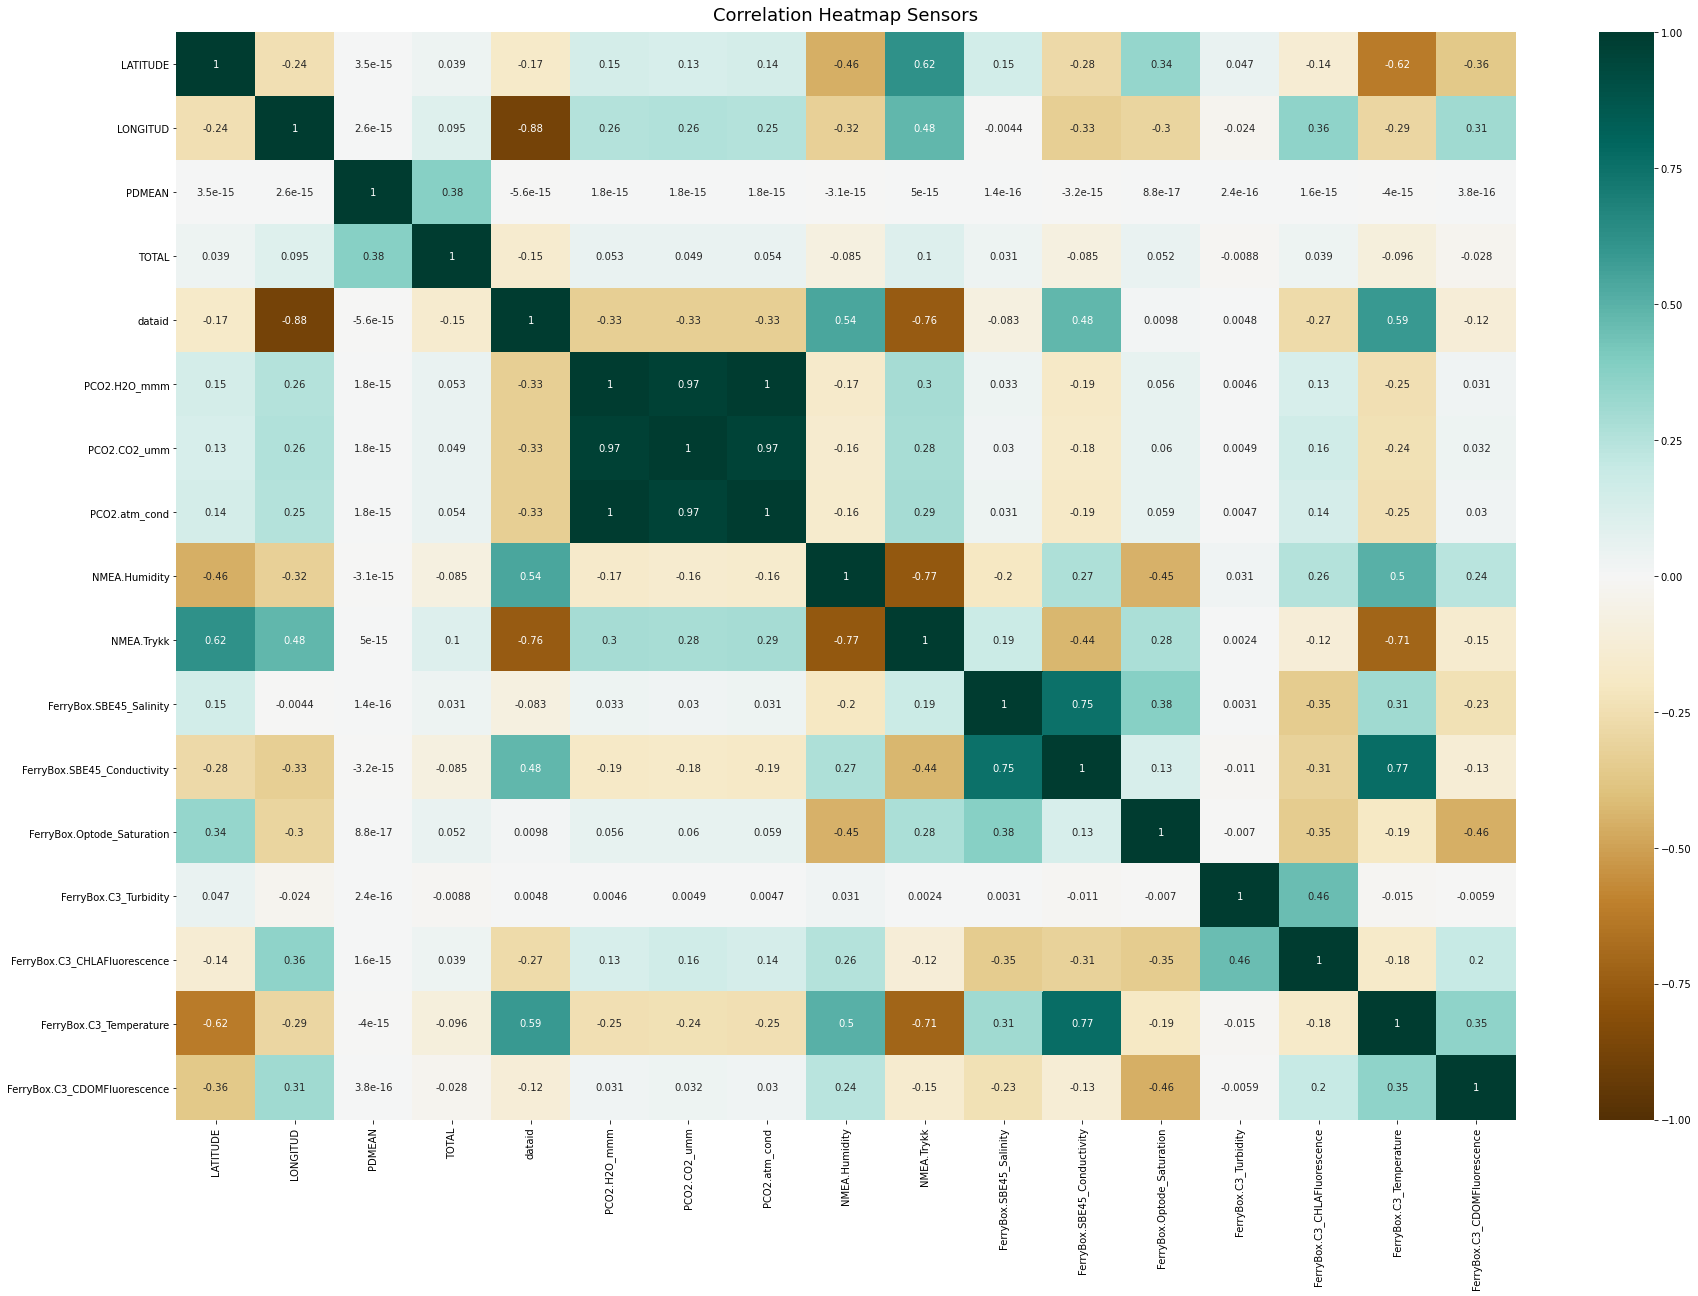

In [96]:
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = final_df.corr()
plt.figure(figsize=(30, 20))
heatmap = sn.heatmap(corrMatrix, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap Sensors', fontdict={'fontsize':18}, pad=12);
plt.show()

figure = heatmap.get_figure()   
figure.savefig('corr.jpg', dpi=300, bbox_inches='tight')

In [97]:
final_df

,LATITUDE,LONGITUD,PDMEAN,TOTAL,dataid,PCO2.H2O_mmm,PCO2.CO2_umm,PCO2.atm_cond,NMEA.Humidity,NMEA.Trykk,FerryBox.SBE45_Salinity,FerryBox.SBE45_Conductivity,FerryBox.Optode_Saturation,FerryBox.C3_Turbidity,FerryBox.C3_CHLAFluorescence,FerryBox.C3_Temperature,FerryBox.C3_CDOMFluorescence
0,26.68929,-29.05914,7.5,0.0000,1643441400000000000,0.505,200.735001,4.965,60.750000,1019.711578,36.591,5.2895,93.019997,12.04,-0.45,22.750,-0.135
1,26.68929,-29.05914,15.0,4.3472,1643441400000000000,0.505,200.735001,4.965,60.750000,1019.711578,36.591,5.2895,93.019997,12.04,-0.45,22.750,-0.135
2,26.68929,-29.05914,25.0,10.4678,1643441400000000000,0.505,200.735001,4.965,60.750000,1019.711578,36.591,5.2895,93.019997,12.04,-0.45,22.750,-0.135
3,26.68929,-29.05914,35.0,12.3473,1643441400000000000,0.505,200.735001,4.965,60.750000,1019.711578,36.591,5.2895,93.019997,12.04,-0.45,22.750,-0.135
4,26.68929,-29.05914,45.0,14.3287,1643441400000000000,0.505,200.735001,4.965,60.750000,1019.711578,36.591,5.2895,93.019997,12.04,-0.45,22.750,-0.135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43211,23.19454,-40.66192,685.0,35.0402,1645304400000000000,0.000,0.000000,0.000,85.858334,1008.785004,35.882,5.7965,94.059998,-0.38,-0.45,28.405,-0.150
43212,23.19454,-40.66192,695.0,45.1827,1645304400000000000,0.000,0.000000,0.000,85.858334,1008.785004,35.882,5.7965,94.059998,-0.38,-0.45,28.405,-0.150
43213,23.19454,-40.66192,705.0,351.3631,1645304400000000000,0.000,0.000000,0.000,85.858334,1008.785004,35.882,5.7965,94.059998,-0.38,-0.45,28.405,-0.150
43214,23.19454,-40.66192,715.0,42.6268,1645304400000000000,0.000,0.000000,0.000,85.858334,1008.785004,35.882,5.7965,94.059998,-0.38,-0.45,28.405,-0.150


In [83]:
final_df.to_csv('leg4_combined_without_pco2_0.csv', index = False)

In [ ]:
ferrybox_data_c = pd.DataFrame(ferrybox_data_c)

ferrybox_data_c =gpd.GeoDataFrame(

    ferrybox_data_c, geometry=gpd.points_from_xy(ferrybox_data_c.latitude, ferrybox_data_c.longitude))

ferrybox_data_c.reset_index(level=0, inplace=True)

ferrybox_data_c['timestamp'] = ferrybox_data_c['timestamp'].astype(str)

ferrybox_data_c = ferrybox_data_c.dropna()